In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from paretoset import paretoset

import sys
sys.path.append('../')
sys.path.append('../usecase_cd')
sys.path.append('../qnetsur')

plt.style.use("seaborn-v0_8-paper")

font = 16
plt.rcParams.update({
    'text.usetex': False,
    'font.family': 'arial',
    'font.size': font,
    'axes.labelsize': font,  
    'xtick.labelsize': font,  
    'ytick.labelsize': font, 
    'legend.fontsize': font,
    'legend.title_fontsize': font,
    'axes.titlesize': font
})
import warnings
warnings.filterwarnings("ignore")

## Tutorial: Analysis of collected Pareto frontier 

This notebook serves as tutorial for analysing solutions for multiple-optimization objectives (=Pareto frontier).
1. We will look into how we can retrieve these solutions of a random 2D sample set.
2. We will investigate 
* our smallest network topology, the **(2,1)-tree**, and two random tree networks
* a random **20-node tree network**
* a random **100-node tree network**


BUT BEFORE START, download [TU4LINK] and set the folder path to

`folder3n = /path/to/QENTSUR-DATA/continuous_distribution_protocols/notebook_cd_n3/`

`folder20n = /path/to/QENTSUR-DATA/continuous_distribution_protocols/notebook_cd_n20/`

`folder100n = /path/to/QENTSUR-DATA/continuous_distribution_protocols/cd_1h/`


In [44]:
folder3n = '//Users/localadmin/Downloads/qnetsur-data/continuous_distribution_protocols/notebook_cd_n3/'
folder20n = '/Users/localadmin/Downloads/qnetsur-data/continuous_distribution_protocols/notebook_cd_n20/'
folder100n = '/Users/localadmin/Downloads/qnetsur-data/continuous_distribution_protocols/cd_10h/'

### 1. Pareto front of a random 2D sample set 

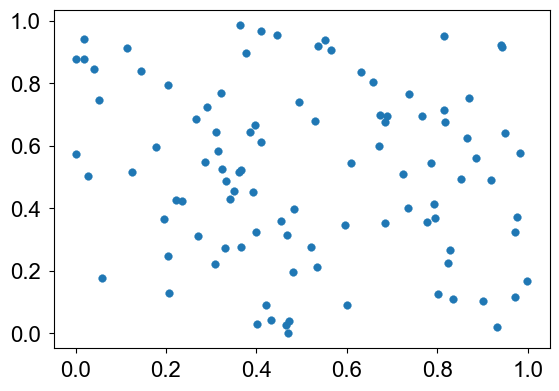

In [45]:
a = 0
b = 1
sample = (b-a) * np.random.random_sample((2,100)) + a
plt.scatter(x=sample[0], y=sample[1])
plt.show()

The Pareto frontier of the collected sample can be easiliy retrieved with `paretoset()` an algorithm implemented by [Tommy Otland, 2021](https://tommyodland.com/articles/2020/pareto-non-dominated-front-as-a-consumer-strategy/#notes-and-references) and is marked in orange below.

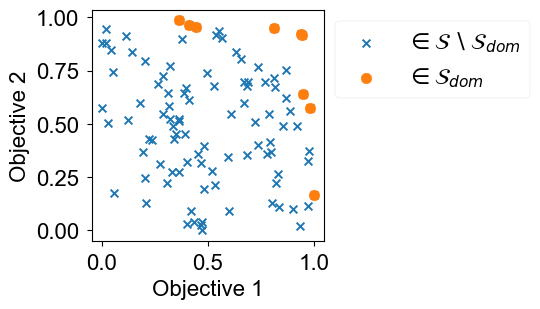

In [46]:
filter = paretoset(sample.T, sense=["max", "max"])
fig, ax = plt.subplots(figsize=[3,3])
plt.ylabel('Objective 2')
plt.xlabel('Objective 1')
plt.scatter(x=sample[0], y=sample[1], label=r'$\in \mathcal{S}\setminus \mathcal{S}_{dom}$', marker='x')
plt.scatter(x=sample[0][filter], y=sample[1][filter], label=r'$\in \mathcal{S}_{dom}$', s=60)
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.tight_layout()
#plt.savefig('simple-pareto.pdf', bbox_inches="tight")

### 2. Pareto analysis of (2,1)-tree of collected solution set

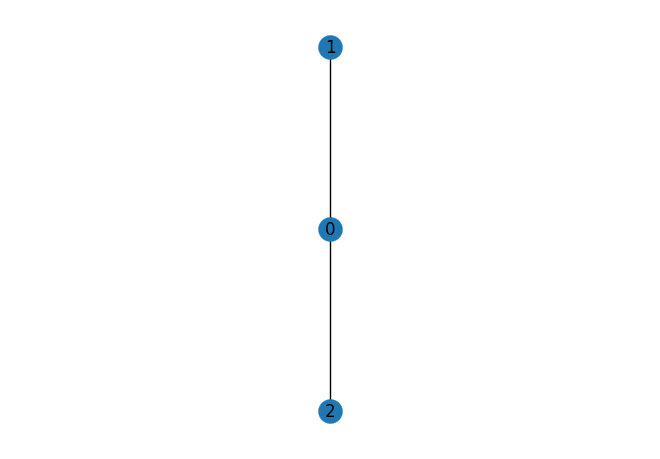

In [47]:
import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout

T = nx.balanced_tree(2, 1)

pos = graphviz_layout(T, prog="twopi")
nx.draw(T, pos, with_labels=True)
plt.show()

Load result data from the online storage as mentioned above or run `python surrogate.py --topo tree-2-1 --level --iterator 30 ` (45 min runtime). `config.py` is set with the following parameters

* 'protocol': 'ndsrs',
* 'p_gen': 0.9,
* 'p_swap': 1,
* 'return_data': 'avg',
* 'progress_bar': None,
* 'total_time': 1000,
* 'N_samples': 1000,
* 'p_cons': 0.225,
* 'qbits_per_channel': 5,
* 'cutoff': 28,
* 'M': 2,
* 'A': array([[0, 1, 1],
        [1, 0, 0],
        [1, 0, 0]])

In [48]:
df = pd.read_csv(folder3n+'SU_tree-2-1_100cycles_SEED42_06-26-2024_16:30:08.csv')

<Figure size 640x440 with 0 Axes>

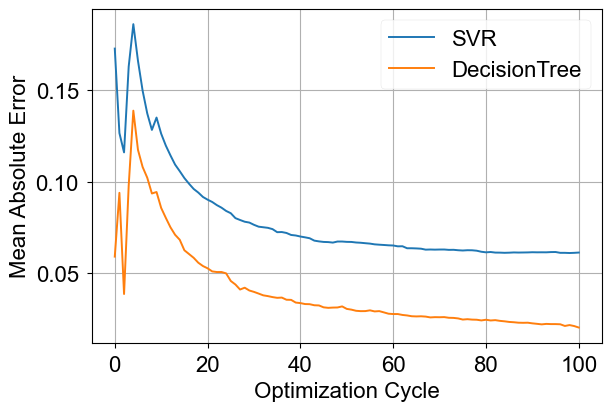

In [49]:
plt.figure()
df[['SVR', 'DecisionTree']].apply(pd.unique).plot()
plt.xlabel('Optimization Cycle')
plt.ylabel('Mean Absolute Error')
plt.grid()
plt.tight_layout()
#plt.savefig('cd_tree-2-1_mlbenchmarks.pdf')
plt.show()

Excursion: How to calculate which cutoff time to set (given total runtime $T$, $M$, $F_\mathrm{new}$ and $F_\mathrm{app}$ according to [Inesta et al.,2023](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.108.052615))

In [50]:
T = 1000
M = 4
Fnew = 0.888
Fapp = 0.6
-T*np.log( 3/(4*Fnew-1) * ((4*Fapp-1)/3)**(1/M) )

np.float64(28.800089826157972)

In [51]:
virtual_neighbors = df[df.columns[df.columns.str.fullmatch('\d+')]]

Again calculate the Pareto frontier of the collected set $S_\mathrm{Parto}$

In [52]:
vn = virtual_neighbors.to_numpy()
filter = paretoset(vn, sense=["max"]*3)
print(len(filter))

1010


In [53]:
sum(filter)

np.int64(35)

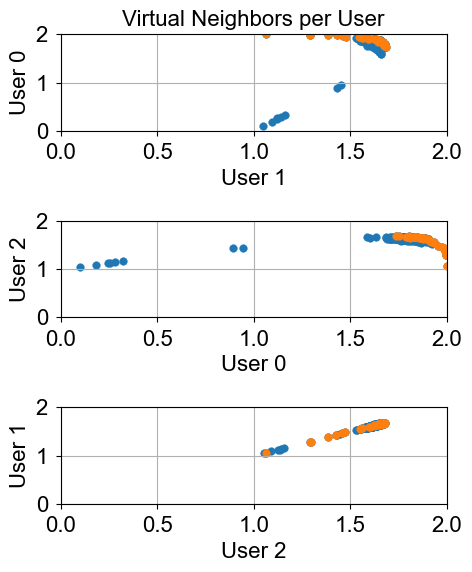

In [54]:
fig, axs = plt.subplots(3,sharey=False, sharex=False, figsize=[5,6])
labels = [1,0,2,1]
for i,ax in enumerate(axs):
    ax.scatter(x=vn[:,labels[i]], y=vn[:,labels[i+1]])
    ax.scatter(x=vn[:,labels[i]][filter], y=vn[:,labels[i+1]][filter])
    ax.set_xlabel(f'User {labels[i]}')
    ax.set_ylabel(f'User {labels[i+1]}')
    ax.set_ylim([0,2])
    ax.set_xlim([0,2])
    ax.grid()
axs[0].set_title('Virtual Neighbors per User')
plt.tight_layout()
plt.show()

And as 3D version

In [55]:
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline
virtual_neighbors['filter'] = filter
fig = px.scatter_3d(virtual_neighbors, x=virtual_neighbors.columns[0], y=virtual_neighbors.columns[1], z=virtual_neighbors.columns[2],
              color='filter')
plt.tight_layout()
fig.show()

<Figure size 640x440 with 0 Axes>

Now, we will plot the distribution of the probability values in $S_\mathrm{Parto}$

In [56]:
X_df = df[df.columns[df.columns.str.contains('q_swap')]]
X_df

,q_swap0,q_swap1
0,0.773956,0.370798
1,0.438878,0.926765
2,0.858598,0.643865
3,0.697368,0.822762
4,0.094177,0.443414
...,...,...
1005,0.228157,0.316919
1006,0.228156,0.329244
1007,0.221747,0.386376
1008,0.214009,0.286360


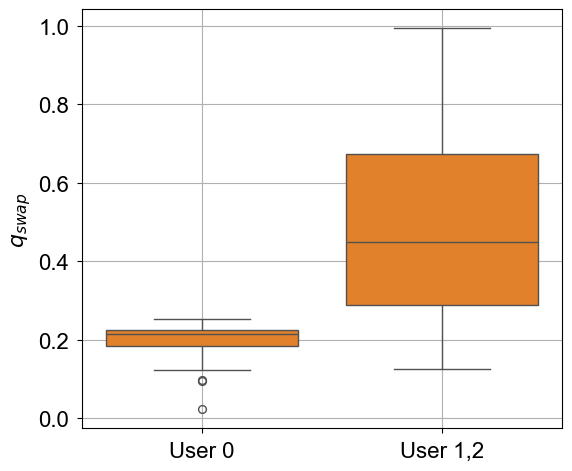

In [57]:
fig, ax = plt.subplots(figsize=(6,5))
g = sns.boxplot(X_df[filter], palette=['tab:orange'])
g.set_xticklabels(['User 0', 'User 1,2'])
plt.ylabel(r'$q_{swap}$')
plt.grid()
plt.tight_layout()
plt.savefig('cd-21tree-pareto.pdf')
plt.show()

We can see that the parameter distribution in the dominating set pretty much coveres the optimal aggregated behaviour of the simulation (in terms of achieved virtual neighbors for each user):

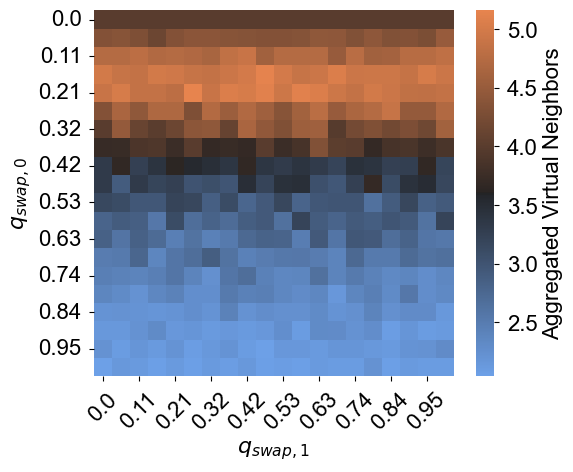

In [58]:
cmap = sns.diverging_palette(250, 30, l=65, center="dark", as_cmap=True)
df_plot = pd.read_pickle('../../surdata/cd_n3/tree-2-1-heatmap.pkl')
fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(df_plot, cmap=cmap, cbar_kws={'label': 'Aggregated Virtual Neighbors'})
plt.xlabel(r'$q_{swap,1}$')
plt.ylabel(r'$q_{swap,0}$')
plt.yticks(rotation=0) 
plt.xticks(rotation=45) 
plt.tight_layout()
plt.savefig('cd-21tree-heatmap.pdf')

Text(0.5, 0, 'q_swap')

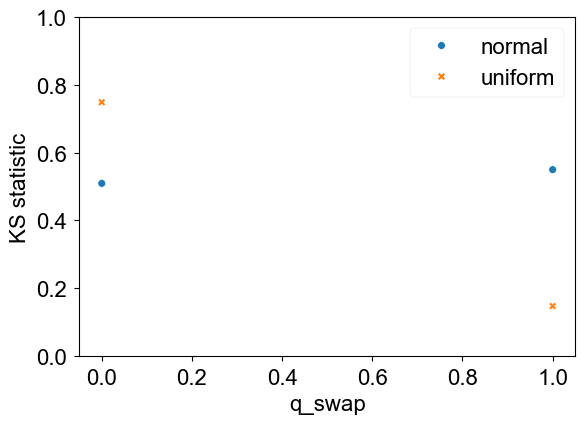

In [59]:
from scipy import stats
df_ks_norm = X_df[filter].apply(lambda x: stats.kstest(x, stats.norm.cdf)[0])
df_ks_uniform = X_df[filter].apply(lambda x: stats.kstest(x, stats.uniform.cdf)[0])
df_plot = pd.concat([df_ks_norm, df_ks_uniform], axis=1).reset_index()
df_plot.columns = ['q_swap','normal', 'uniform']
sns.scatterplot(df_plot)
plt.ylim([0,1])
plt.ylabel('KS statistic')
plt.xlabel('q_swap')

Now, we will go to a larger layout, a random **20-node tree network** involving 7 users:

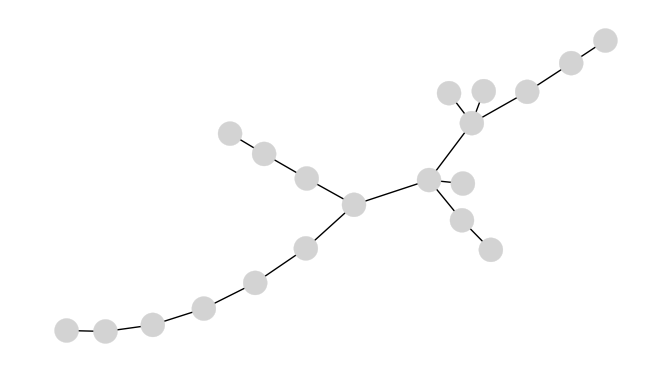

In [100]:
n=20
graph = nx.random_tree(n, seed=7)
fig, ax = plt.subplots(figsize=(7,4))
pos = nx.spring_layout(graph, scale=2, seed=3)
colors = ['lightgrey'] * n
nx.draw(graph, pos, with_labels=True, node_color=colors, node_size=300)
plt.tight_layout()
plt.savefig('cd-random-tree20-pareto-graph-plain.pdf')

Load the result data of the surrogate optimization (or execute it with according parameters) and again retrieve the dominating set from the collected training data:

In [61]:
df = pd.read_csv(folder20n+'SU_randtree-20_100cycles_SEED42_06-26-2024_13:25:43.csv')

In [62]:
df.columns = df.columns.astype('str')
vn = df[df.columns[df.columns.str.fullmatch('\d+')]]
df_q = df[df.columns[df.columns.str.contains('q_swap')]]

We get the following values for the overall virtual neighbors

In [63]:
vn

,0,1,2,3,4,5,6
0,1.474747,1.818182,1.333333,2.151515,1.313131,1.141414,1.404040
1,1.626263,2.111111,2.020202,1.343434,1.959596,1.303030,1.717172
2,1.383838,1.373737,1.505051,1.727273,1.555556,1.484848,2.212121
3,0.858586,1.545455,1.929293,1.818182,1.757576,1.020202,1.323232
4,1.595960,1.181818,1.626263,1.888889,1.464646,2.101010,1.161616
...,...,...,...,...,...,...,...
1005,2.323232,2.121212,2.393939,2.555556,2.424242,1.959596,2.414141
1006,2.454545,2.363636,2.383838,2.363636,2.464646,2.353535,2.373737
1007,2.555556,2.303030,2.414141,2.575758,2.464646,2.626263,2.404040
1008,2.414141,2.525253,2.303030,2.555556,2.404040,2.373737,2.272727


... from which we retrieve the dominating set

In [64]:
def get_pareto_frontier(vn, q_set):
    vn_to_analyse = vn
    filter = paretoset(vn_to_analyse, sense=["max"]*vn_to_analyse.shape[1])
    return q_set[filter], sum(filter)

(this can take a few seconds)

In [65]:
df_q_filtered, size = get_pareto_frontier(vn, df_q)
size

np.int64(121)

Let's look at the overall distribution of swap probability values in the dominating set

In [66]:
graph.degree

DegreeView({0: 1, 1: 4, 2: 4, 3: 2, 4: 2, 5: 1, 6: 2, 7: 2, 8: 1, 9: 1, 10: 2, 11: 2, 12: 2, 13: 3, 14: 1, 15: 1, 16: 2, 17: 2, 18: 2, 19: 1})

In [67]:
import re 
df_melted = df_q_filtered.melt(var_name='Node', value_name='Probability')
df_melted['Node Degree'] = df_melted['Node'].apply(lambda x: graph.degree[int(re.sub(r"\D", "", x))])
df_melted_sorted = df_melted.sort_values('Node Degree')
df_melted_sorted[['Node Degree', 'Probability']].corr()

,Node Degree,Probability
Node Degree,1.000000,0.858987
Probability,0.858987,1.000000


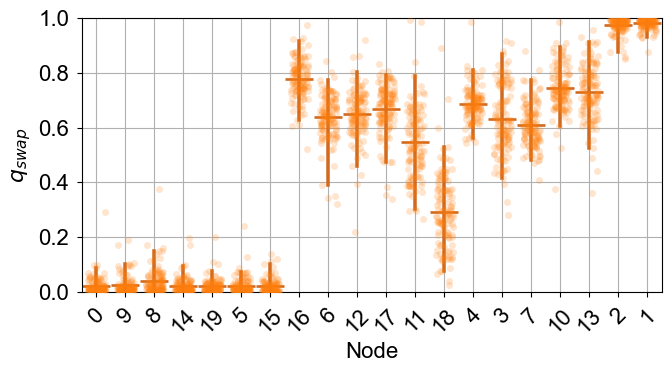

In [99]:
import re
cmap =  light_orange_palette = sns.light_palette('tab:orange', n_colors=10, reverse=False, as_cmap=True)

fig, ax = plt.subplots(figsize = [7,4])
sns.stripplot(data=df_melted_sorted, x="Node", y="Probability", jitter=0.3, alpha=.2, dodge=True, legend=False, color='tab:orange', ax=ax)
sns.pointplot(df_melted_sorted, x='Node', y='Probability', errorbar='pi', ax=ax, linestyles='', color='chocolate', markers='_', markersize=20)
labels = [re.sub('\D', '', label.get_text()) for label in ax.get_xticklabels()]
ax.set_xticklabels(labels, rotation=45)
plt.ylabel(r'$q_{swap}$')
plt.grid()
plt.ylim([0,1])
plt.tight_layout()
plt.savefig('cd-random-tree20-pareto.pdf')

In [ ]:
fig, ax = plt.subplots(figsize=(7,4))
pos = nx.spring_layout(graph, scale=2, seed=3)
colors = ['lightgrey'] * n
for idx in labels:
    colors[int(idx)] = cmap(df_q_filtered['q_swap'+idx].mean()) if df_q_filtered['q_swap'+idx].std() <= 0.1 else 'lightblue'
nx.draw(graph, pos, with_labels=True, node_color=colors, node_size=300)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = 0, vmax=1))
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label(r'$q_{swap}$', labelpad=15, rotation=270)
plt.tight_layout()
plt.savefig('cd-random-tree20-pareto-graph.pdf')

In [ ]:
df_plot

In [ ]:
from scipy import stats
df_ks_norm = df_q_filtered.apply(lambda x: stats.kstest(x, stats.norm.cdf)[0])
df_ks_uniform = df_q_filtered.apply(lambda x: stats.kstest(x, stats.uniform.cdf)[0])
df_plot = pd.concat([df_ks_norm, df_ks_uniform], axis=1).reset_index()
df_plot.columns = ['Node', 'normal', 'uniform']
df_plot_sorted = df_melted_sorted.merge(df_plot, how='left', on='Node')

fig, ax = plt.subplots(figsize = [7,4])
sns.pointplot(df_plot_sorted, x='Node', y='Probability', errorbar='pi', ax=ax, linestyles='', color='tab:orange')#{node: cmap(val) for node, val in dict(df_q_filtered.mean()).items()}, )
sns.pointplot(df_plot_sorted, x='Node', y='normal', ax=ax, linestyles='')
sns.pointplot(df_plot_sorted, x='Node', y='uniform', ax=ax, linestyles='', color='green')
plt.xlabel('Node')
labels = [re.sub('\D', '', label.get_text()) for label in ax.get_xticklabels()]
ax.set_xticklabels(labels, rotation=45)
plt.ylabel(r'$q_{swap}$')
plt.grid()
plt.ylim([0,1])
plt.tight_layout()

In [ ]:
# Create the figure and the axes
fig, ax = plt.subplots(figsize=[7, 4])

# Plotting the 'Probability' data on the first y-axis
sns.pointplot(data=df_plot_sorted, x='Node', y='Probability', errorbar='pi', ax=ax, linestyles='', color='tab:orange', label=r'$q_{swap}$')

# Create a second y-axis
ax2 = ax.twinx()

# Plotting 'normal' and 'uniform' on the second y-axis
sns.pointplot(data=df_plot_sorted, x='Node', y='normal', ax=ax2, linestyles='', color='tab:blue', label='KS to Normal')
sns.pointplot(data=df_plot_sorted, x='Node', y='uniform', ax=ax2, linestyles='', color='tab:green', label='KS to Uniform')

# Customizing the left y-axis to be orange
ax.spines['left'].set_color('tab:orange')
ax.yaxis.label.set_color('tab:orange')
ax.tick_params(axis='y', colors='tab:orange')

# Labeling axes
ax.set_xlabel('Node')
ax.set_ylabel(r'$q_{swap}$')
ax2.set_ylabel('KS statistic')
# Adjusting the tick labels for readability
labels = [re.sub('\D', '', label.get_text()) for label in ax.get_xticklabels()]
ax.set_xticklabels(labels, rotation=45)

# Adding a legend to differentiate the plots
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left', bbox_to_anchor=(1.2, 1))
ax.legend(lines + lines2, labels + labels2, loc='upper left', bbox_to_anchor=(1.2, 1))

# Set limits for the y-axes
ax.set_ylim([0, 1])

# Adding grid and layout adjustments
plt.grid()

# Show plot
plt.show()

The last layout we will investigate is a **100-node network** involing 39 users

In [ ]:
n=100
graph = nx.random_tree(n, seed=7)
fig, ax = plt.subplots(figsize=(7,4))
pos = nx.spring_layout(graph, scale=2, seed=3)
colors = ['lightgrey'] * n
nx.draw(graph, pos, with_labels=True, node_color=colors, node_size=300)

In [ ]:
import pandas as pd
import glob
files = glob.glob(folder100n+'SU*.csv')
dfs = []
for file in files:
    df = pd.read_csv(file, index_col=0)
    dfs.append(df)

df = pd.concat(dfs, axis=0)

vn = df[df.columns[df.columns.astype('str').str.fullmatch('\d+')]]
df_q = df[df.columns[df.columns.astype('str').str.contains('q_swap')]]
print(df)

In [ ]:
vn

Let's again retrieve the dominating set (can take a few seconds)

In [ ]:
df_q_filtered, size = get_pareto_frontier(vn, df_q)
size

Most distributions are widely spread with a sd above 0.2.

In [ ]:
df_q_filtered.std(axis=0)[df_q_filtered.std(axis=0) < 0.2]

In [ ]:
cmap =  light_orange_palette = sns.light_palette('tab:orange', n_colors=10, reverse=False, as_cmap=True)

fig, ax = plt.subplots(figsize = [7,4])
sns.pointplot(df_q_filtered[df_q_filtered.columns[df_q_filtered.std(axis=0) < 0.2]], palette={'tab:orange'}, errorbar='sd', ax=ax)#{node: cmap(val) for node, val in dict(df_q_filtered.mean()).items()}, )
plt.xlabel('Node')
labels = [re.sub('\D', '', label.get_text()) for label in ax.get_xticklabels()]
ax.set_xticklabels(labels, rotation=45)
plt.ylabel(r'$q_{swap}$')
plt.grid()
plt.ylim([0,1])
plt.tight_layout()
plt.savefig('cd-random-tree100-pareto.pdf')

At last, let's look at the best found solution of the largest dataset (since we cannot gain too much insight from the Pareto set anymore)

In [ ]:
qvals = df_q.iloc[vn.sum(axis=1).argmax()]
print(qvals)

In [ ]:
n=100
pos = nx.spring_layout(graph, scale=2, seed=2)
graph = nx.random_tree(n, seed=7)
nx.draw(graph, pos= pos, node_size=50, node_color='grey')
plt.savefig('plaintree100.pdf')

In [ ]:

cmap =  sns.light_palette('tab:orange', n_colors=10, reverse=False, as_cmap=True)
fig, ax = plt.subplots(figsize=(15,8))
pos = nx.spring_layout(graph, scale=2, seed=2)
colors = [cmap(qswap_mean) for qswap_mean in qvals]
labels = {node: round(val,1) for node, val in enumerate(qvals)}
nx.draw(graph, pos, with_labels=False, node_color=colors, node_size=300)
nx.draw_networkx_labels(graph, pos, labels=labels)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = 0, vmax=1))
plt.title(r'Best Found Solution with Time Limit $T = 10$ h')
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label(r'$q_{swap}$', labelpad=15, rotation=270)
plt.tight_layout()
plt.savefig('cd-random-tree-best.pdf')

In [ ]:
from scipy import stats
df_ks_norm = df_q_filtered.apply(lambda x: stats.kstest(x, stats.norm.cdf)[0])
df_ks_uniform = df_q_filtered.apply(lambda x: stats.kstest(x, stats.uniform.cdf)[0])
df_plot = pd.concat([df_ks_norm, df_ks_uniform], axis=1).reset_index()
df_plot.columns = ['Node', 'normal', 'uniform']

df_melted = df_q_filtered.melt(var_name='Node', value_name='Probability')
df_melted['Node Degree'] = df_melted['Node'].apply(lambda x: graph.degree[int(re.sub(r"\D", "", x))])
df_melted_sorted = df_melted.sort_values('Node Degree')
df_plot_sorted = df_melted_sorted.merge(df_plot, how='left', on='Node')

# Create the figure and the axes
fig, ax = plt.subplots(figsize=[30, 4])

# Plotting the 'Probability' data on the first y-axis
sns.pointplot(data=df_plot_sorted, x='Node', y='Probability', errorbar='pi', ax=ax, linestyles='', color='tab:orange', label=r'$q_{swap}$')

# Create a second y-axis
ax2 = ax.twinx()

# Plotting 'normal' and 'uniform' on the second y-axis
sns.pointplot(data=df_plot_sorted, x='Node', y='normal', ax=ax2, linestyles='', color='tab:blue', label='KS to Normal')
sns.pointplot(data=df_plot_sorted, x='Node', y='uniform', ax=ax2, linestyles='', color='tab:green', label='KS to Uniform')

# Customizing the left y-axis to be orange
ax.spines['left'].set_color('tab:orange')
ax.yaxis.label.set_color('tab:orange')
ax.tick_params(axis='y', colors='tab:orange')

# Labeling axes
ax.set_xlabel('Node')
ax.set_ylabel(r'$q_{swap}$')
ax2.set_ylabel('KS statistic')
# Adjusting the tick labels for readability
labels = [re.sub('\D', '', label.get_text()) for label in ax.get_xticklabels()]
ax.set_xticklabels(labels, rotation=45)

# Adding a legend to differentiate the plots
labels = [re.sub('\D', '', label.get_text()) for label in ax.get_xticklabels()]
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left', bbox_to_anchor=(1.05, 1))
ax.legend(lines + lines2, labels + labels2, loc='upper left', bbox_to_anchor=(1.05, 1))

# Set limits for the y-axes
ax.set_ylim([0, 1])

# Adding grid and layout adjustments
plt.grid()

# Show plot
plt.show()